```shell
conda create --name zarr python=3.9 numpy matplotlib zarr xarray ipykernel gcsfs fsspec dask

```

Explanation of the coordinates within the Zarr:

* time: The time the satellite image was taken, in UTC.
* variable: The satellite channel name. In the HRV dataset there is only one channel: The "high resolution visible" channel.
* x and y: The geospatial position of each pixel. In summary, the x and y values are the number of meters from south west corner of Great Britain. In more detail: the x and y values are "eastings" and "northings" in the "[OSGB 1936 / British National Grid -- United Kingdom Ordnance Survey](https://epsg.io/27700)" grid reference system (EPSG 27700). See [this WikiPedia page for more information](https://en.wikipedia.org/wiki/Ordnance_Survey_National_Grid#All-numeric_grid_references).

In [1]:
import xarray as xr
import pandas as pd

In [2]:
SOURCE_PATH = "gs://solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/v2/*.zarr"

In [3]:
def drop_duplicate_times(data_array: xr.DataArray, time_dim: str = "time") -> xr.DataArray:
    """
    Drop duplicate times in data array
    Args:
        data_array: main data
        class_name: the data source name
        time_dim: the time dimension we want to look at
    Returns: data array with no duplicated times
    """
    # If there are any duplicated init_times then drop the duplicated init_times:
    time = pd.DatetimeIndex(data_array[time_dim])
    if not time.is_unique:
        n_duplicates = time.duplicated().sum()
        print(f"Zarr has {n_duplicates:,d} duplicated init_times.  Fixing...")
        data_array = data_array.drop_duplicates(dim=time_dim)
        
    assert pd.DatetimeIndex(data_array[time_dim]).is_unique

    return data_array

In [4]:
def remove_acq_time_from_dataset_and_dedupe_time_coords(dataset: xr.Dataset) -> xr.Dataset:
    """
    Preprocess datasets by dropping `acq_time`, which causes problems otherwise. Also de-duplicate time coords.

    Args:
        dataset: xr.Dataset to preprocess
    Returns:
        dataset with acq_time dropped
    """
    dataset = dataset.drop_vars("acq_time", errors="ignore")

    # If there are any duplicated init_times then drop the duplicated time:
    stacked_eumetsat_data = drop_duplicate_times(data_array=dataset["stacked_eumetsat_data"])

    dataset = stacked_eumetsat_data.to_dataset(name="stacked_eumetsat_data")
    assert pd.DatetimeIndex(stacked_eumetsat_data["time"]).is_unique
    assert pd.DatetimeIndex(stacked_eumetsat_data["time"]).is_monotonic_increasing
    return dataset


def open_hrv_data_array(source_path: str, use_same_chunks_as_zarr: bool = False) -> xr.DataArray:
    """Lazily open HRV data.
    
    Args:
      source_path: The path with the source Zarrs.
      use_same_chunks_as_zarr: If True then the returned DataArray will have the same chunk sizes
          as the Zarr stores. This is useful if copying the data to a new Zarr. If False then let
          dask automatically pick chunk sizes. This usually
          results in faster data access and processing.
    """
    dataset = xr.open_mfdataset(
        source_path,
        chunks={} if use_same_chunks_as_zarr else "auto",
        mode="r",
        engine="zarr",
        concat_dim="time",
        preprocess=remove_acq_time_from_dataset_and_dedupe_time_coords,
        combine="nested",
        consolidated=True
    )
    data_array = dataset["stacked_eumetsat_data"]
    data_array = data_array.sel(variable="HRV").drop_vars("variable")
    data_array = data_array.transpose("time", "y", "x")
    assert pd.DatetimeIndex(data_array["time"]).is_monotonic_increasing
    return data_array

In [5]:
%%time
data_array = open_hrv_data_array(SOURCE_PATH, use_same_chunks_as_zarr=True)

Zarr has 1 duplicated init_times.  Fixing...
Zarr has 1 duplicated init_times.  Fixing...
Zarr has 1 duplicated init_times.  Fixing...
Zarr has 1 duplicated init_times.  Fixing...
Zarr has 1 duplicated init_times.  Fixing...
Zarr has 8 duplicated init_times.  Fixing...
CPU times: user 58.7 s, sys: 5.29 s, total: 1min 4s
Wall time: 3min 37s


In [6]:
data_array

<xarray.DataArray 'stacked_eumetsat_data' (time: 173624, y: 891, x: 1843)>
dask.array<transpose, shape=(173624, 891, 1843), dtype=int16, chunksize=(1, 450, 475), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float64 1.347e+06 1.346e+06 1.345e+06 ... -6.9e+05 -6.912e+05
  * y        (y) float64 -5.565e+05 -5.549e+05 ... 1.394e+06 1.397e+06
Attributes:
    meta:     {'orbital_parameters': {'projection_longitude': 9.5, 'projectio...

In [7]:
import re
p = re.compile(r'^.*(\'osgb_x_coords\'.*)$')
#p.match("foo \'osgb_x_coords\' bar")
p.match(data_array.attrs['meta'].replace("\n", "\\n")).groups()

("'osgb_x_coords': array([[ 1347260.78970861,  1346210.5893596 ,  1345160.38427426, ...,\\n         -688720.46785782,  -689951.871242  ,  -691183.51645387],\\n       [ 1347022.64648326,  1345972.42557608,  1344922.19989872, ...,\\n         -689084.16408769,  -690315.72056065,  -691547.51903694],\\n       [ 1346784.34726589,  1345734.10578477,  1344683.85949961, ...,\\n         -689448.1639533 ,  -690679.87373616,  -691911.82569837],\\n       ...,\\n       [ 1032877.09360205,  1031798.02144526,  1030718.87513805, ...,\\n        -1359672.48508876, -1362010.43508464, -1364359.01271138],\\n       [ 1032304.99563913,  1031225.86865627,  1030146.66731761, ...,\\n        -1362923.03824863, -1365288.94353461, -1367666.17689064],\\n       [ 1031731.86495733,  1030652.68304692,  1029573.4265744 , ...,\\n        -1366253.50206751, -1368649.37096581, -1371057.35481592]]), 'osgb_y_coords': array([[-556533.00010717, -556688.40058675, -556843.57445542, ...,\\n        -441006.48538256, -440677.9195304

CPU times: user 3.87 s, sys: 211 ms, total: 4.08 s
Wall time: 4.09 s


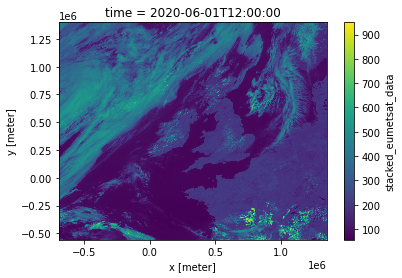

In [8]:
%%time
data_array.sel(time="2020-06-01 12:00").plot();

In [9]:
data_array.encoding

{'chunks': (1, 475, 450, 1),
 'preferred_chunks': {'time': 1, 'x': 475, 'y': 450, 'variable': 1},
 'compressor': Blosc(cname='zstd', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'dtype': dtype('int16'),
 'coordinates': 'acq_time'}

## Plot fancy map

See https://xarray.pydata.org/en/stable/user-guide/plotting.html#maps

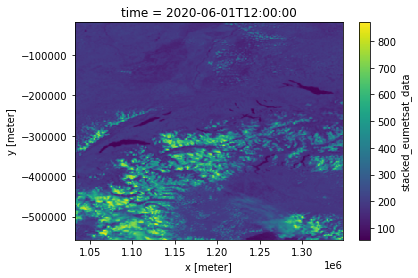

In [10]:
data_array.sel(time="2020-06-01 12:00").isel(x=slice(0, 300), y=slice(0, 300)).plot()

In [11]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

/tmp/ipykernel_882010/96029212.py:2: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  ax = plt.axes(projection=ccrs.OSGB())


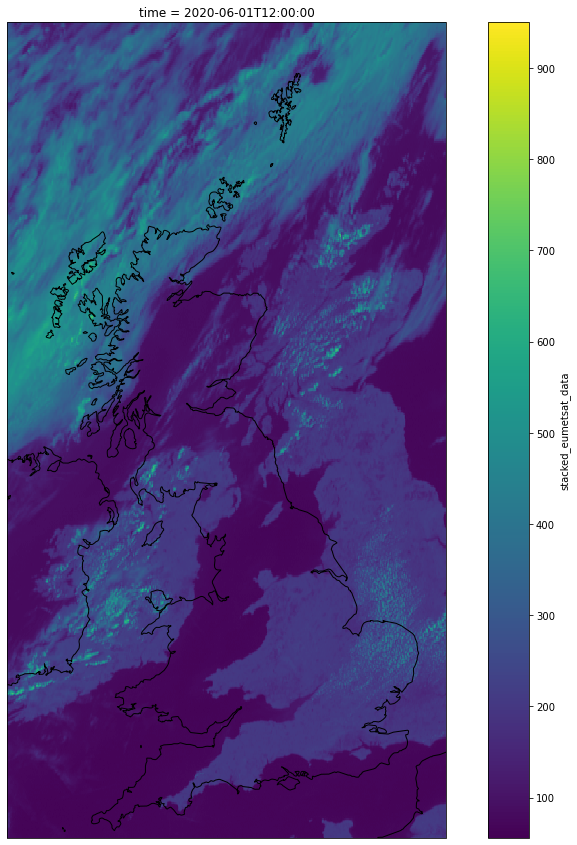

In [12]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=ccrs.OSGB())
p = data_array.sel(time="2020-06-01 12:00").plot(ax=ax)
ax.coastlines()

## plot the boundaries of the data

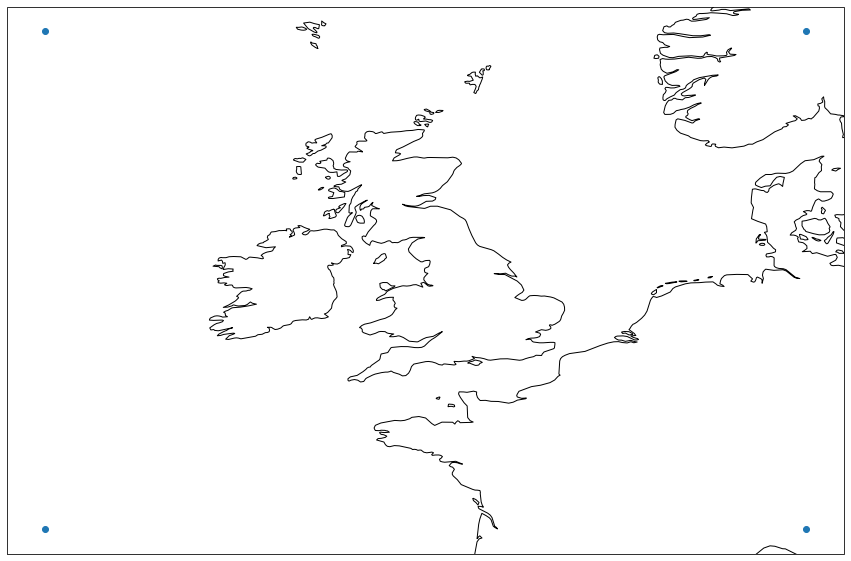

In [13]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(
    x=[-16, 10, -16, 10],
    y=[45, 45, 62, 62]
)
ax.coastlines()

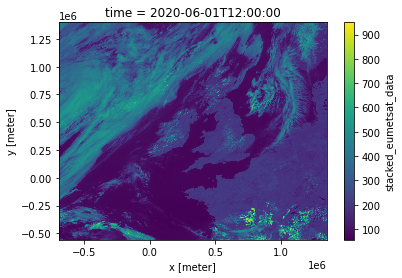

In [14]:
data_array.sel(time="2020-06-01 12:00").plot();

## Load native satellite image to extract coords and metadata

In [15]:
import satpy

In [16]:
NATIVE_FILENAME = "/mnt/solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/native/2020/06/01/12/04/MSG3-SEVI-MSG15-0100-NA-20200601120416.752000000Z-NA.nat"
scene = satpy.Scene(reader="seviri_l1b_native", filenames=[NATIVE_FILENAME])
scene.load(["HRV"])

In [17]:
scene["HRV"]

/home/jack/miniconda3/envs/zarr/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


<xarray.DataArray 'reshape-420ba234fe34910f8287a0f890cc932f' (y: 4176, x: 5568)>
dask.array<mul, shape=(4176, 5568), dtype=float32, chunksize=(1392, 5568), chunktype=numpy.ndarray>
Coordinates:
    acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT NaT ... NaT NaT NaT NaT NaT
    crs       object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",...
  * y         (y) float64 1.395e+06 1.396e+06 1.397e+06 ... 5.57e+06 5.571e+06
  * x         (x) float64 2.824e+06 2.823e+06 ... -2.742e+06 -2.743e+06
Attributes:
    orbital_parameters:                     {'projection_longitude': 9.5, 'pr...
    sun_earth_distance_correction_applied:  True
    sun_earth_distance_correction_factor:   1.0282367454433767
    units:                                  %
    wavelength:                             0.7 µm (0.5-0.9 µm)
    standard_name:                          toa_bidirectional_reflectance
    platform_name:                          Meteosat-10
    sensor:                                 seviri
    georef_offset_corrected:                True
    start_time:                             2020-06-01 12:00:10.306957
    end_time:                               2020-06-01 12:05:10.242182
    reader:                                 seviri_l1b_native
    area:                                   Area ID: msg_seviri_rss_1km\nDesc...
    name:                                   HRV
    resolution:                             1000.134348869
    calibration:                            reflectance
    modifiers:                              ()
    _satpy_id:                              DataID(name='HRV', wavelength=Wav...
    ancillary_variables:                    []

In [18]:
scene = scene.crop(ll_bbox=(-16, 45, 10, 62))

/home/jack/miniconda3/envs/zarr/lib/python3.9/site-packages/pyresample/spherical.py:118: RuntimeWarning: invalid value encountered in true_divide
  self.cart /= np.sqrt(np.einsum('...i, ...i', self.cart, self.cart))


In [19]:
scene["HRV"]

/home/jack/miniconda3/envs/zarr/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


<xarray.DataArray 'reshape-420ba234fe34910f8287a0f890cc932f' (y: 891, x: 1843)>
dask.array<getitem, shape=(891, 1843), dtype=float32, chunksize=(891, 1843), chunktype=numpy.ndarray>
Coordinates:
    acq_time  (y) datetime64[ns] 2020-06-01T12:02:57.707000 ... 2020-06-01T12...
    crs       object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",...
  * y         (y) float64 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
  * x         (x) float64 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
Attributes:
    orbital_parameters:                     {'projection_longitude': 9.5, 'pr...
    sun_earth_distance_correction_applied:  True
    sun_earth_distance_correction_factor:   1.0282367454433767
    units:                                  %
    wavelength:                             0.7 µm (0.5-0.9 µm)
    standard_name:                          toa_bidirectional_reflectance
    platform_name:                          Meteosat-10
    sensor:                                 seviri
    georef_offset_corrected:                True
    start_time:                             2020-06-01 12:00:10.306957
    end_time:                               2020-06-01 12:05:10.242182
    reader:                                 seviri_l1b_native
    area:                                   Area ID: msg_seviri_rss_1km\nDesc...
    name:                                   HRV
    resolution:                             1000.134348869
    calibration:                            reflectance
    modifiers:                              ()
    _satpy_id:                              DataID(name='HRV', wavelength=Wav...
    ancillary_variables:                    []

In [20]:
area = scene["HRV"].attrs["area"]
area

Area ID: msg_seviri_rss_1km
Description: MSG SEVIRI Rapid Scanning Service area definition with 1 km resolution
Projection: {'a': '6378169', 'h': '35785831', 'lon_0': '9.5', 'no_defs': 'None', 'proj': 'geos', 'rf': '295.488065897014', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 1843
Number of rows: 891
Area extent: (28503.8289, 5088183.4999, -1814743.776, 4197063.795)

In [21]:
import pyproj
lat_lon_to_osgb = pyproj.Transformer.from_crs(crs_from=4326, crs_to=27700)

In [22]:
%%time
lon, lat = area.get_lonlats()

CPU times: user 439 ms, sys: 0 ns, total: 439 ms
Wall time: 438 ms


In [23]:
%%time
x_osgb, y_osgb = lat_lon_to_osgb.transform(lat, lon)

CPU times: user 609 ms, sys: 0 ns, total: 609 ms
Wall time: 606 ms


In [24]:
native_dataset = scene.to_xarray_dataset()
native_dataset

/home/jack/miniconda3/envs/zarr/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


<xarray.Dataset>
Dimensions:   (y: 891, x: 1843)
Coordinates:
    acq_time  (y) datetime64[ns] 2020-06-01T12:02:57.707000 ... 2020-06-01T12...
    crs       object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",...
  * y         (y) float64 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
  * x         (x) float64 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
Data variables:
    HRV       (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Attributes: (12/19)
    orbital_parameters:                     {'projection_longitude': 9.5, 'pr...
    sun_earth_distance_correction_applied:  True
    sun_earth_distance_correction_factor:   1.0282367454433767
    units:                                  %
    wavelength:                             0.7 µm (0.5-0.9 µm)
    standard_name:                          toa_bidirectional_reflectance
    ...                                     ...
    name:                                   HRV
    resolution:                             1000.134348869
    calibration:                            reflectance
    modifiers:                              ()
    _satpy_id:                              DataID(name='HRV', wavelength=Wav...
    ancillary_variables:                    []

In [25]:
native_dataset = native_dataset.assign_coords(
    x_osgb=(('y', 'x'), x_osgb),
    y_osgb=(('y', 'x'), y_osgb),
)
native_dataset

<xarray.Dataset>
Dimensions:   (y: 891, x: 1843)
Coordinates:
    acq_time  (y) datetime64[ns] 2020-06-01T12:02:57.707000 ... 2020-06-01T12...
    crs       object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",...
  * y         (y) float64 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
  * x         (x) float64 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb    (y, x) float64 1.347e+06 1.346e+06 ... -1.369e+06 -1.371e+06
    y_osgb    (y, x) float64 -5.565e+05 -5.567e+05 ... 2.503e+06 2.507e+06
Data variables:
    HRV       (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Attributes: (12/19)
    orbital_parameters:                     {'projection_longitude': 9.5, 'pr...
    sun_earth_distance_correction_applied:  True
    sun_earth_distance_correction_factor:   1.0282367454433767
    units:                                  %
    wavelength:                             0.7 µm (0.5-0.9 µm)
    standard_name:                          toa_bidirectional_reflectance
    ...                                     ...
    name:                                   HRV
    resolution:                             1000.134348869
    calibration:                            reflectance
    modifiers:                              ()
    _satpy_id:                              DataID(name='HRV', wavelength=Wav...
    ancillary_variables:                    []

## Merge

In [29]:
import numpy as np

In [30]:
data_array = data_array.assign_coords(
    x_osgb=(('y', 'x'), np.float32(x_osgb)),
    y_osgb=(('y', 'x'), np.float32(y_osgb)),
)

data_array

<xarray.DataArray 'stacked_eumetsat_data' (time: 173624, y: 891, x: 1843)>
dask.array<transpose, shape=(173624, 891, 1843), dtype=int16, chunksize=(1, 450, 475), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float64 1.347e+06 1.346e+06 1.345e+06 ... -6.9e+05 -6.912e+05
  * y        (y) float64 -5.565e+05 -5.549e+05 ... 1.394e+06 1.397e+06
    x_osgb   (y, x) float32 1.347e+06 1.346e+06 ... -1.369e+06 -1.371e+06
    y_osgb   (y, x) float32 -5.565e+05 -5.567e+05 ... 2.503e+06 2.507e+06
Attributes:
    meta:     {'orbital_parameters': {'projection_longitude': 9.5, 'projectio...

In [31]:
data_array['x'] = np.float32(native_dataset.x)
data_array['y'] = np.float32(native_dataset.y)
data_array['x'].attrs = native_dataset.x.attrs
data_array['y'].attrs = native_dataset.y.attrs

In [41]:
for name in ['x_osgb', 'y_osgb']:
    data_array[name].attrs = {'units': 'meter', 'coordinate_reference_system': 'OSGB'}
    
data_array.x_osgb.attrs['name'] = 'Easting'
data_array.y_osgb.attrs['name'] = 'Northing'

for name in ['x', 'y']:
    data_array[name].attrs['coordinate_reference_system'] = 'geostationary'

In [33]:
attrs = native_dataset.attrs.copy()

In [34]:
del attrs['start_time']
del attrs['end_time']
del attrs['units']

In [35]:
import yaml

In [36]:

import pyresample

In [37]:
# To save to Zarr, the value of each attr must be a number or string
for attr_key in attrs:
    value = attrs[attr_key]
    
    # Convert Dicts
    if isinstance(value, dict):
        # Convert np.float32 to Python floats (otherwise json complains)
        for inner_key in value:
            inner_value = value[inner_key]
            if isinstance(inner_value, np.floating):
                value[inner_key] = float(inner_value)
        attrs[attr_key] = yaml.dump(value)
        
    # Convert bools
    if isinstance(value, (bool, np.bool_)):
        attrs[attr_key] = str(value)
        
    # Convert area
    if isinstance(value, pyresample.geometry.AreaDefinition):
        attrs[attr_key] = value.dump()

In [38]:
data_array.attrs = attrs

In [39]:
data_array = data_array.drop_vars("acq_time", errors="ignore")
data_array = data_array.drop_vars("crs", errors="ignore")

In [42]:
data_array

<xarray.DataArray 'stacked_eumetsat_data' (time: 173624, y: 891, x: 1843)>
dask.array<transpose, shape=(173624, 891, 1843), dtype=int16, chunksize=(1, 450, 475), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    x_osgb   (y, x) float32 1.347e+06 1.346e+06 ... -1.369e+06 -1.371e+06
    y_osgb   (y, x) float32 -5.565e+05 -5.567e+05 ... 2.503e+06 2.507e+06
Attributes:
    orbital_parameters:                     projection_altitude: 35785831.0\n...
    sun_earth_distance_correction_applied:  True
    sun_earth_distance_correction_factor:   1.0282367454433767
    wavelength:                             0.7 µm (0.5-0.9 µm)
    standard_name:                          toa_bidirectional_reflectance
    platform_name:                          Meteosat-10
    sensor:                                 seviri
    georef_offset_corrected:                True
    reader:                                 seviri_l1b_native
    area:                                   msg_seviri_rss_1km:\n  descriptio...
    name:                                   HRV
    resolution:                             1000.134348869
    calibration:                            reflectance
    modifiers:                              ()
    _satpy_id:                              !!python/object/apply:satpy.datas...
    ancillary_variables:                    []

/tmp/ipykernel_882010/4022811832.py:2: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  ax = plt.axes(projection=ccrs.OSGB())
/tmp/ipykernel_882010/4022811832.py:6: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  transform=ccrs.OSGB(),


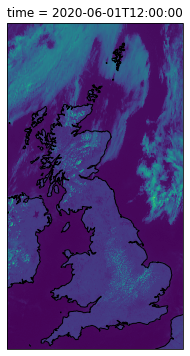

In [43]:
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.OSGB())

data_array.sel(time="2020-06-01 12:00").plot.pcolormesh(
    ax=ax, 
    transform=ccrs.OSGB(), 
    x="x_osgb", 
    y="y_osgb", 
    add_colorbar=False,
)
ax.coastlines();

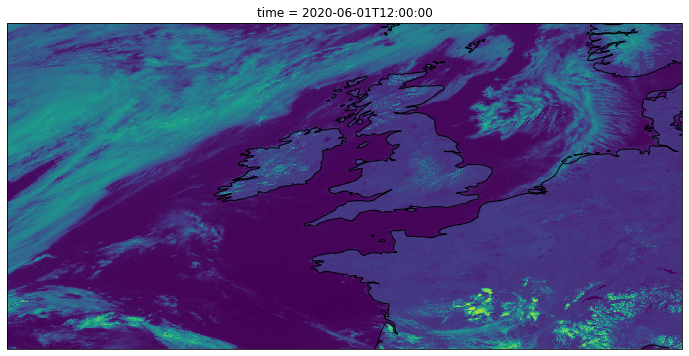

In [44]:
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.Geostationary(central_longitude=9.5))

data_array.sel(time="2020-06-01 12:00").plot.pcolormesh(
    ax=ax, 
    transform=ccrs.Geostationary(central_longitude=9.5), 
    x="x", 
    y="y", 
    add_colorbar=False,
)
ax.coastlines();

## Save as new zarr

In [45]:
new_dataset = data_array.to_dataset(name="data")

In [50]:
new_dataset = new_dataset.chunk({'time': 1, 'x': -1, 'y': -1})

In [51]:
new_dataset

<xarray.Dataset>
Dimensions:  (time: 173624, x: 1843, y: 891)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    x_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
    y_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Data variables:
    data     (time, y, x) int16 dask.array<chunksize=(1, 891, 1843), meta=np.ndarray>

In [47]:
import numcodecs

In [ ]:
%%time
new_zarr = new_dataset.to_zarr(
    "gs://solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/v3/eumetsat_seviri_hrv_uk.zarr",
    mode="w",
    consolidated=True,
    compute=True,
    encoding={
        "data": {
            "compressor": numcodecs.get_codec(dict(id='bz2', level=5)),
        },
        "time": {"units": "nanoseconds since 1970-01-01"},
    },

)

In [60]:
loaded_ds = xr.open_dataset("gs://solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/v3/eumetsat_seviri_hrv_uk.zarr", engine="zarr", mode="r")

In [61]:
loaded_ds

<xarray.Dataset>
Dimensions:  (time: 50, y: 891, x: 1843)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2020-01-01T04:10:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 ...
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 ...
Data variables:
    data     (time, y, x) int16 ...

In [62]:
loaded_ds['data'].encoding

{'chunks': (1, 891, 1843),
 'preferred_chunks': {'time': 1, 'y': 891, 'x': 1843},
 'compressor': BZ2(level=5),
 'filters': None,
 'dtype': dtype('int16')}

In [ ]:
loaded_ds['data']